In [1]:
import pandas as pd
import numpy as np

## Selenium & PhantomJS 를 이용하여 Web Scraping 

In [2]:
# Web Scraping Tool - AJAX 기반 (비동기식 자바스크립트)
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from bs4 import BeautifulSoup

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
url = "https://www.google.com/flights/explore/#explore;f=JFK,EWR,LGA;t=HND,NRT,TPE,HKG,KIX;s=1;li=8;lx=12;d=2018-03-01"
# PJS_PATH = "/Applications/anaconda3/pkgs/phantomjs-2.1.1-0/bin"
driver = webdriver.PhantomJS()
dcap = dict(DesiredCapabilities.PHANTOMJS)
dcap["phantomjs.page.settings.userAgent"] = ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36")
driver = webdriver.PhantomJS(desired_capabilities=dcap, service_args=['--ignore-ssl-errors=true'])
driver.implicitly_wait(20)
driver.get(url)

/Applications/anaconda3/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '
/Applications/anaconda3/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


In [11]:
driver.save_screenshot(r'flight_explorer.png')

True

## DOM 분석을 통한 가격 데이터 추출

DOM: 웹페이지의 구조를 만드는 요소들의 집합
(Body, div, class, id 등)

In [12]:
s = BeautifulSoup(driver.page_source, "lxml")

<!DOCTYPE html>
<html lang="en-US"><head><meta content="text/html; charset=utf-8" http-equiv="content-type"/><meta content="baseUrl=/flights/explore//static/" name="deals::gwt:property"/><title>Explore flights</title><meta content="Explore flights" name="description"/><script async="" src="https://apis.google.com/_/scs/abc-static/_/js/k=gapi.gapi.en.QiBse7P5SjM.O/m=gapi_iframes,googleapis_client,plusone/rt=j/sv=1/d=1/ed=1/am=AAE/rs=AHpOoo9jYrE1LfQSZTrVx2QGL0mG9OVMow/cb=gapi.loaded_0"></script><script language="javascript" type="text/javascript">
var __JS_ILT__ = new Date();
</script>
<style type="text/css">.gb_5a{background:white;height:100%;position:fixed;right:0;top:0;width:420px;z-index:1001}.gb_6a.gb_5a{left:0;min-height:400px;top:64px;width:initial}.gb_5a>button:only-of-type{background:url('https://www.gstatic.com/images/icons/material/system/1x/close_grey600_24dp.png');background-position:center;border-width:0;cursor:pointer;font-size:24px;height:20px;left:92%;position:relative;t
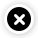
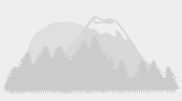

In [13]:
s

In [14]:
best_price_tags = s.findAll('div', 'CTPFVNB-w-e') 
best_prices = []
for tag in best_price_tags:
    best_prices.append(int(tag.text.replace('$','')))

In [15]:
best_price_tags

[<div class="CTPFVNB-w-e" style="top: 23.782261153185644px;">$628</div>,
 <div class="CTPFVNB-w-e" style="top: 16.01957978360595px;">$635</div>,
 <div class="CTPFVNB-w-e" style="top: 32.921234655657926px;">$757</div>,
 <div class="CTPFVNB-w-e" style="top: 25.44199980784515px;">$871</div>]

In [16]:
best_price = best_prices[0]
best_price

628

In [17]:
best_height_tags = s.find_all('div', 'CTPFVNB-w-f')
best_height_tags

[<div class="CTPFVNB-w-x CTPFVNB-w-f CTPFVNB-w-M" style="left: 18px; height: 82.21773884681436px;"></div>,
 <div class="CTPFVNB-w-x CTPFVNB-w-f" style="left: 24px; height: 89.98042021639405px;"></div>,
 <div class="CTPFVNB-w-x CTPFVNB-w-f" style="left: 234px; height: 73.07876534434207px;"></div>,
 <div class="CTPFVNB-w-x CTPFVNB-w-f CTPFVNB-w-M" style="left: 270px; height: 80.55800019215485px;"></div>]

In [20]:
best_height_tags = s.find_all('div', 'CTPFVNB-w-f')
best_heights = []
for tag in best_height_tags:
    best_heights.append(float(tag.attrs['style']\
                              .split('height:')[1].replace('px;','')))
    
'''
tag.attrs -> style: , height: (2개의 attribute로 구성)
style 부분을 제외하고 height: 을 기준으로 나누어 2번째 text 가져오기
px; 부분을 공백으로 바꾸기

'''

In [36]:
best_height = best_heights[0]
best_height

82.21773884681436

In [37]:
# Price per height
pph = np.array(best_price)/np.array(best_height)
pph

7.6382543330469224

In [40]:
cities = s.findAll('div', 'CTPFVNB-w-o')
len(cities)

4

In [41]:
hlist=[]
for bar in cities[0]\
    .findAll('div', 'CTPFVNB-w-x'):
    hlist.append(float(bar['style']\
                       .split('height: ')[1].replace('px;',''))*pph)

In [47]:
fares = pd.DataFrame(hlist, columns = ['price'])

In [50]:
fares.describe()

,price
count,60.000000
mean,720.079525
std,67.488780
min,628.000000
25%,628.000000
50%,747.036014
75%,771.643459
max,809.654959


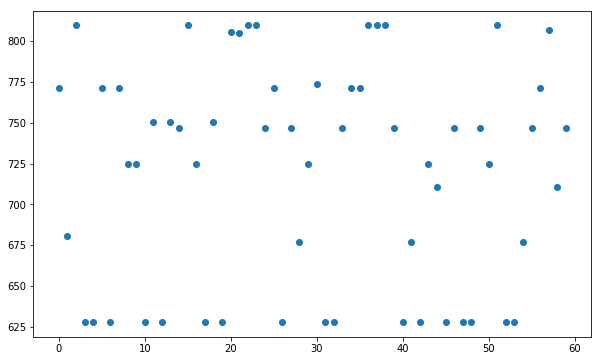

In [53]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(np.arange(len(fares['price'])), fares['price'])

In [55]:
# Price 데이터프레임 설정 (무작위재정렬?)
px = [x for x in fares['price']]
ff = pd.DataFrame(px, columns = ['fare']).reset_index()

In [54]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [64]:
X = StandardScaler().fit_transform(ff)
db = DBSCAN(eps = .5, min_samples = 1).fit(X)

Text(0.5,1.01,'Total Clusters: 11')

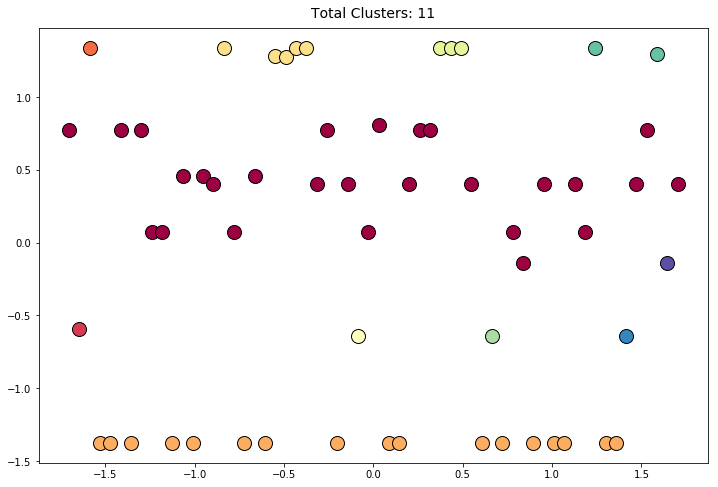

In [84]:
labels = db.labels_
clusters = len(set(labels))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

plt.subplots(figsize = (12, 8))
for k, c in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o',
             markerfacecolor = c,
             markeredgecolor = 'k',
             markersize = 14)
plt.title("Total Clusters: {}".format(clusters), fontsize = 14, y = 1.01)
